In [ ]:
# --- Instala as bibliotecas ---
# A biblioteca ultralytics já contém o PyTorch e outras dependências essenciais.
# Usamos '-q' para uma instalação mais "silenciosa".
!pip install ultralytics -q

# --- Importa as bibliotecas ---
import os
import cv2
import random
import shutil
from tqdm import tqdm
from google.colab import drive
from ultralytics import YOLO

# --- Monta o Google Drive ---
# Irá pedir autorização na primeira vez.
print("Conectando ao Google Drive...")
drive.mount('/content/drive')
print("Google Drive conectado com sucesso!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Conectando ao Google Drive...
Mounted at /content/drive
Google Drive conectado com sucesso!


In [ ]:
# --- Mapeamento das Classes ---
# Dicionário para traduzir os IDs das pastas para nomes legíveis
# (não usado no treino, mas útil para referência e futuros logs)
CLASS_NAMES = {
    "50000262": "Smartwatch",
    "50001708": "Moedor de Graos",
    "50001726_2": "Mixer",
    "50001861": "Liquidificador",
    "50001986": "Secador de Cabelo"
}

# --- Caminhos no Google Drive ---
BASE_PATH = "/content/drive/MyDrive/Tese_Mestrado/No_Annotation"
VIDEOS_PATH = os.path.join(BASE_PATH, "Videos")
FRAMES_PATH = os.path.join(BASE_PATH, "Frames_extract")
MODELS_PATH = os.path.join(BASE_PATH, "Models")

# --- Parâmetros de Extração e Treino ---
FRAMES_PER_SECOND = 1  # Quantos frames extrair por segundo de vídeo
VALIDATION_SPLIT = 0.2 # Usaremos 20% dos dados para validação
EXPERIMENT_NAME = "Classificacao_5_Classes_V1" # Nome da pasta onde o modelo será salvo

In [ ]:
print("Iniciando a extração de frames...")
os.makedirs(FRAMES_PATH, exist_ok=True)

for class_id in os.listdir(VIDEOS_PATH):
    class_video_path = os.path.join(VIDEOS_PATH, class_id)
    class_frame_path = os.path.join(FRAMES_PATH, class_id)

    if not os.path.isdir(class_video_path):
        continue

    os.makedirs(class_frame_path, exist_ok=True)

    video_files = [f for f in os.listdir(class_video_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]

    print(f"\nProcessando {len(video_files)} vídeos para a classe: {class_id}...")
    for video_file in tqdm(video_files):
        video_filepath = os.path.join(class_video_path, video_file)
        cap = cv2.VideoCapture(video_filepath)

        if not cap.isOpened():
            print(f"Aviso: Não foi possível abrir o vídeo {video_file}. Pulando.")
            continue

        fps = int(cap.get(cv2.CAP_PROP_FPS))
        intervalo = max(1, fps // FRAMES_PER_SECOND)

        frame_count = 0
        saved_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % intervalo == 0:
                output_filename = f"{os.path.splitext(video_file)[0]}_frame_{saved_count}.jpg"
                cv2.imwrite(os.path.join(class_frame_path, output_filename), frame)
                saved_count += 1
            frame_count += 1
        cap.release()

print("\nExtração de frames concluída!")

Iniciando a extração de frames...

Processando 258 vídeos para a classe: 50001708...


100%|██████████| 258/258 [02:44<00:00,  1.57it/s]



Processando 92 vídeos para a classe: 50001726_2...


100%|██████████| 92/92 [01:38<00:00,  1.07s/it]



Processando 86 vídeos para a classe: 50001861...


100%|██████████| 86/86 [01:11<00:00,  1.20it/s]



Processando 267 vídeos para a classe: 50001986...


100%|██████████| 267/267 [02:03<00:00,  2.15it/s]



Processando 161 vídeos para a classe: 50000262...


100%|██████████| 161/161 [01:49<00:00,  1.47it/s]


Extração de frames concluída!


In [ ]:
print("Preparando o dataset para o treinamento (divisão treino/validação)...")

# Caminho para o dataset final que o YOLO vai usar (será criado no ambiente do Colab para velocidade)
DATASET_FINAL_PATH = "/content/drive/MyDrive/Tese_Mestrado/No_Annotation/dataset_yolo_cls"

# Remove o diretório se ele já existir, para garantir um início limpo
if os.path.exists(DATASET_FINAL_PATH):
    shutil.rmtree(DATASET_FINAL_PATH)

# Cria as pastas de treino e validação
train_path = os.path.join(DATASET_FINAL_PATH, "train")
val_path = os.path.join(DATASET_FINAL_PATH, "val")
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Itera sobre cada classe de frames extraídos
for class_id in os.listdir(FRAMES_PATH):
    source_class_path = os.path.join(FRAMES_PATH, class_id)
    if not os.path.isdir(source_class_path):
        continue

    # Cria as subpastas de classe dentro de train e val
    os.makedirs(os.path.join(train_path, class_id), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_id), exist_ok=True)

    # Pega todos os frames, embaralha e divide
    all_frames = os.listdir(source_class_path)
    random.shuffle(all_frames)

    split_index = int(len(all_frames) * VALIDATION_SPLIT)
    val_frames = all_frames[:split_index]
    train_frames = all_frames[split_index:]

    # Copia os arquivos para os locais corretos
    for frame in train_frames:
        shutil.copy(os.path.join(source_class_path, frame), os.path.join(train_path, class_id, frame))
    for frame in val_frames:
        shutil.copy(os.path.join(source_class_path, frame), os.path.join(val_path, class_id, frame))

print("Dataset preparado com sucesso!")
print("Estrutura final do dataset de classificação:")
!ls {DATASET_FINAL_PATH}

Preparando o dataset para o treinamento (divisão treino/validação)...
Dataset preparado com sucesso!
Estrutura final do dataset de classificação:
train  val


In [ ]:
# --- Carrega um modelo YOLOv8 pré-treinado para CLASSIFICAÇÃO ---
# Note o sufixo '-cls' (classification)
model = YOLO('yolov8n-cls.pt')

# --- Inicia o treinamento ---
print("\nIniciando o treinamento do modelo de classificação...")
print(f"Os resultados serão salvos em tempo real na pasta: {os.path.join(MODELS_PATH, EXPERIMENT_NAME)}")

results = model.train(
    data=DATASET_FINAL_PATH, # Aponta para a pasta que criamos com a estrutura train/val
    epochs=50,              # Número de épocas para o treino (ajuste se necessário)
    imgsz=224,              # Tamanho de imagem comum para classificação
    project=MODELS_PATH,    # Pasta principal no Drive para salvar
    name=EXPERIMENT_NAME,   # Subpasta para este experimento específico
    exist_ok=True           # Permite retomar treinos interrompidos
)

print("\n--- TREINAMENTO CONCLUÍDO! ---")

# --- VERIFICAÇÃO FINAL ---
print("\nVerificando se os modelos foram salvos no Google Drive:")
!ls -l "{os.path.join(MODELS_PATH, EXPERIMENT_NAME)}/weights/"


Iniciando o treinamento do modelo de classificação...
Os resultados serão salvos em tempo real na pasta: /content/drive/MyDrive/Tese_Mestrado/Sem_Annotation/Models/Classificacao_5_Classes_V1
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tese_Mestrado/Sem_Annotation/dataset_yolo_cls, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, 

Arquivo 'results.csv' carregado com sucesso!
Colunas encontradas: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


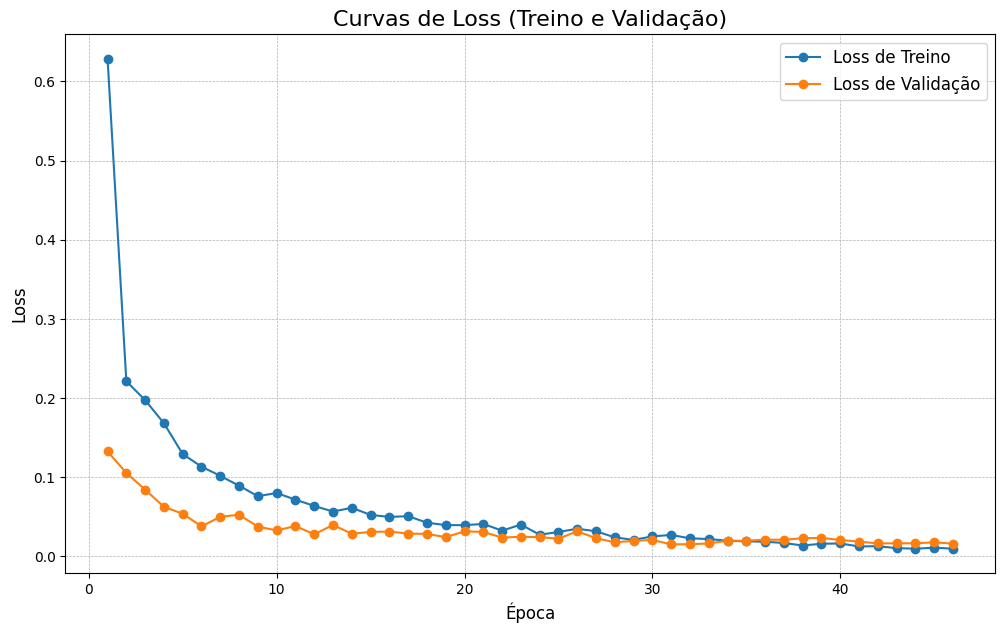

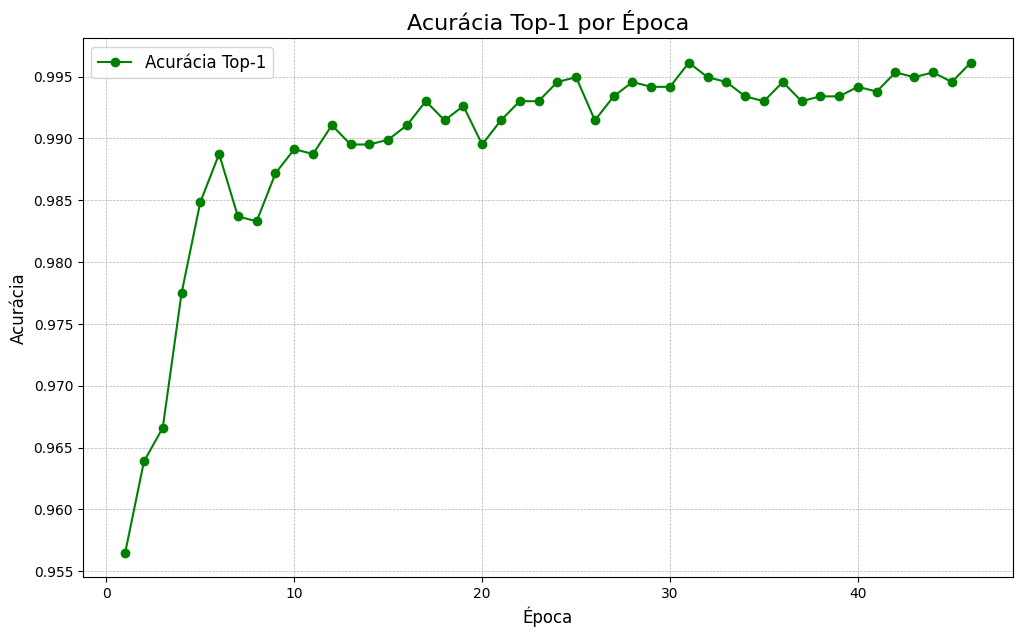

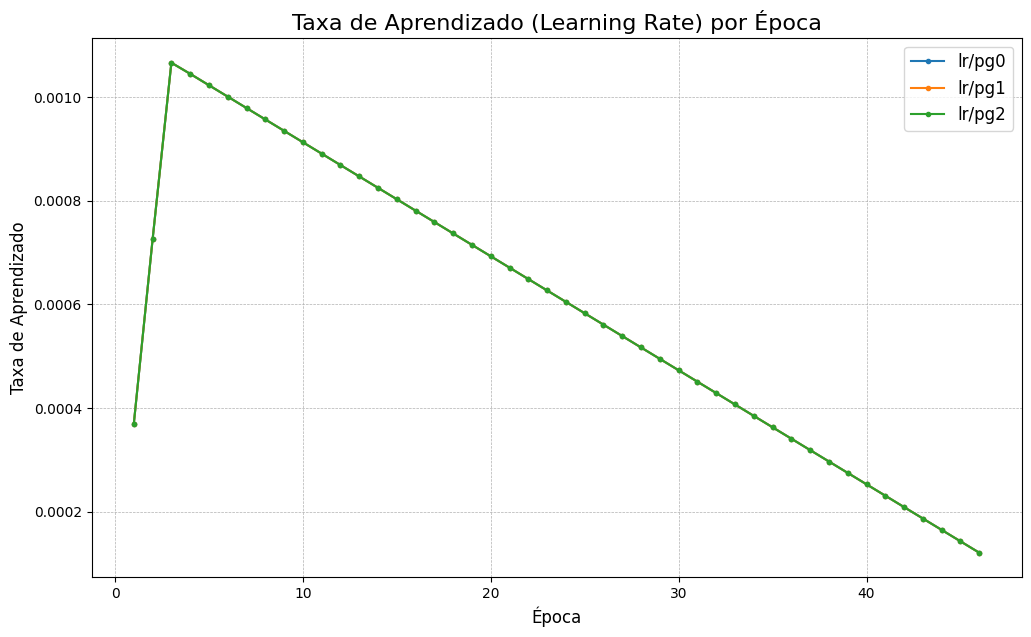


Gráficos salvos com sucesso em: /content/drive/MyDrive/Tese_Mestrado/Sem_Annotation/Models/Classificacao_5_Classes_V1/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Configuração dos Caminhos ---
# O caminho para o arquivo CSV que você upou no Colab.
# Geralmente, '/content/' é o diretório padrão para uploads.
csv_file_path = '/content/drive/MyDrive/Tese_Mestrado/Sem_Annotation/Models/Classificacao_5_Classes_V1/results.csv'

# O diretório onde você quer salvar os gráficos.
# Este é o caminho que você mencionou na sua primeira mensagem.
# Certifique-se de que seu Google Drive está montado se for usar este caminho.
# Exemplo de como montar o Drive: from google.colab import drive; drive.mount('/content/drive')
save_directory = '/content/drive/MyDrive/Tese_Mestrado/Sem_Annotation/Models/Classificacao_5_Classes_V1/'

# Cria o diretório de salvamento se ele não existir
os.makedirs(save_directory, exist_ok=True)


# --- 2. Carregar e Preparar os Dados ---
try:
    # Carrega o arquivo CSV para um DataFrame do pandas
    df = pd.read_csv(csv_file_path)

    # Limpa possíveis espaços em branco nos nomes das colunas
    df.columns = df.columns.str.strip()
    print("Arquivo 'results.csv' carregado com sucesso!")
    print("Colunas encontradas:", df.columns.tolist())

    # --- 3. Geração dos Gráficos ---

    # Gráfico 1: Loss de Treino vs. Validação
    plt.figure(figsize=(12, 7))
    plt.plot(df['epoch'], df['train/loss'], label='Loss de Treino', marker='o', linestyle='-')
    plt.plot(df['epoch'], df['val/loss'], label='Loss de Validação', marker='o', linestyle='-')
    plt.title('Curvas de Loss (Treino e Validação)', fontsize=16)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(os.path.join(save_directory, 'loss_vs_epoca.png'))
    plt.show()

    # Gráfico 2: Acurácia Top-1
    plt.figure(figsize=(12, 7))
    plt.plot(df['epoch'], df['metrics/accuracy_top1'], label='Acurácia Top-1', color='green', marker='o', linestyle='-')
    plt.title('Acurácia Top-1 por Época', fontsize=16)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(os.path.join(save_directory, 'acuracia_vs_epoca.png'))
    plt.show()

    # Gráfico 3: Taxa de Aprendizado (Learning Rate)
    plt.figure(figsize=(12, 7))
    # Plota as colunas de learning rate que existem no seu CSV
    lr_cols = [col for col in df.columns if 'lr/' in col]
    for col in lr_cols:
        plt.plot(df['epoch'], df[col], label=col, marker='.', linestyle='-')
    plt.title('Taxa de Aprendizado (Learning Rate) por Época', fontsize=16)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Taxa de Aprendizado', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(os.path.join(save_directory, 'learning_rate_vs_epoca.png'))
    plt.show()

    print(f"\nGráficos salvos com sucesso em: {save_directory}")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{csv_file_path}' não foi encontrado.")
    print("Por favor, verifique se você fez o upload do arquivo para o Colab e se o nome está correto.")
except KeyError as e:
    print(f"ERRO: Uma coluna esperada não foi encontrada: {e}")
    print("Por favor, verifique se os nomes das colunas no seu CSV correspondem ao esperado pelo código.")